In [2]:
#Automobile_data
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets , transforms
from torch.utils.data import DataLoader ,TensorDataset
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder


# Important Concerns
## 1- Why VAE is a Generative model while the Autoencoder is not ?
## 2- what is the difference between them ?

In [3]:
df=pd.read_csv('automobile_data.csv')

In [4]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [5]:
df.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [7]:
df.isna().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [8]:
numeric_cols=df.select_dtypes(include=['int64','float64']).columns
df_numeric=df[numeric_cols].fillna(df[numeric_cols].mean())

In [9]:
scaler=StandardScaler()
data_scaled=scaler.fit_transform(df_numeric)

In [10]:
data_tensor=torch.FloatTensor(data_scaled)
dataset=TensorDataset(data_tensor)
train_loader=DataLoader(dataset,batch_size=32,shuffle=True)

In [11]:
input_dim=data_scaled.shape[1]
latent_dim=2

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

In [21]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.mu = nn.Linear(16, latent_dim)
        self.logvar = nn.Linear(16, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 16)
        self.fc4 = nn.Linear(16, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return self.fc4(h) 

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [22]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

In [23]:
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [24]:
for epoch in range(50):
    total_loss = 0
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")

Epoch 10, Loss: 10.0279
Epoch 20, Loss: 7.3346
Epoch 30, Loss: 6.7279
Epoch 40, Loss: 6.4221
Epoch 50, Loss: 6.0846


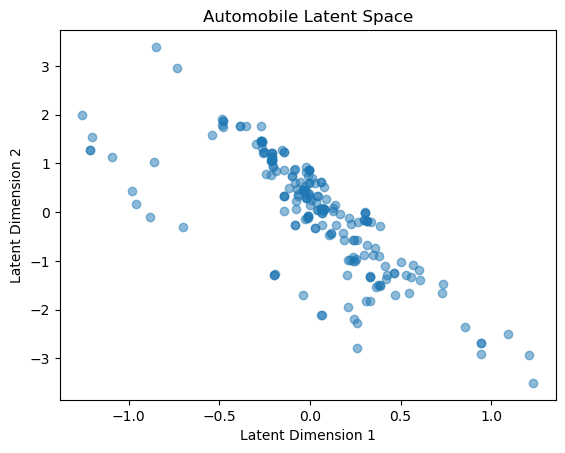

In [25]:
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(data_tensor)
    plt.scatter(mu[:, 0], mu[:, 1], alpha=0.5)
    plt.title("Automobile Latent Space")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

In [19]:
with torch.no_grad():
    z = torch.randn(5, latent_dim) 
    generated_scaled = vae.decode(z).numpy()
    generated_real = scaler.inverse_transform(generated_scaled)
    
    gen_df = pd.DataFrame(generated_real, columns=numeric_cols)
    print("Generated Synthetic Automobiles Specifications:")
    print(gen_df.head())

Generated Synthetic Automobiles Specifications:
   symboling  wheel-base      length      width     height  curb-weight  \
0   0.394854  103.245338  182.988235  67.062012  55.333817  2845.015137   
1   0.839505   97.659164  172.723480  65.661476  53.817329  2460.441650   
2   0.714828   98.689621  174.698883  65.521576  54.560791  2453.351318   
3   0.448552  103.084724  184.510361  67.795387  54.359600  2998.583740   
4   0.987964   96.040352  168.612518  65.226662  53.391647  2313.068604   

   engine-size  compression-ratio   city-mpg  highway-mpg  
0   150.936325          10.553528  22.161255    26.447073  
1   123.684433           9.898361  25.313633    31.330635  
2   123.489174          10.076389  25.120964    31.003166  
3   157.795425          10.227427  20.564951    26.733660  
4   117.034157          10.243299  28.341324    32.993843  
